In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Thu Jan 29 04:49:14 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   49C    P2              78W / 260W |   5790MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
30562 / 48601

0.6288347976379087

In [4]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, Resized, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [6]:
INPUT_PATH = '../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)

In [7]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [8]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [9]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['PRE', 'ART', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE', 'ART', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['PRE', 'ART', 'DEL', 'SEGM'], spatial_size=PATCH_SIZE, padding_mode=('reflection','reflection', 'reflection','reflection'), ),

    #DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    
    
    RandCropByPosNegLabeld(keys=['PRE', 'ART', 'DEL', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['PRE', 'ART', 'DEL', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['PRE', 'ART', 'DEL', 'SEGM'])
])

val_transforms = Compose([
    LoadImaged(keys=['PRE', 'ART', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE', 'ART', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection', 'reflection','reflection')),
    #Resized(keys=['PRE', 'ART', 'DEL', 'LIVER_SEGM'], spatial_size=PATCH_SIZE),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'ART', 'DEL', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['PRE', 'ART', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE', 'ART', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'ART', 'DEL', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['PRE', 'ART', 'DEL'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'DEL']),
    Orientationd(keys=['PRE', 'ART', 'DEL'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'DEL'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear'), padding_mode=('reflection','reflection', 'reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'ART', 'DEL'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [10]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-ART-DEL-Net/monai_cache'

In [11]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [12]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [13]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.5609270334243774
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5724992156028748
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.7320148944854736


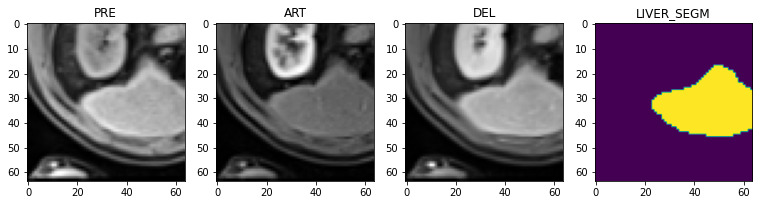

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.33851727843284607
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5374096632003784
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.49494877457618713


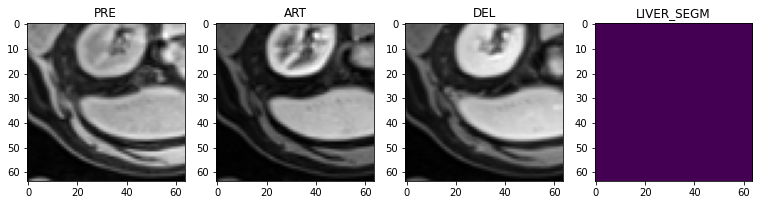

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.46343350410461426
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.4234936833381653
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.5626038312911987


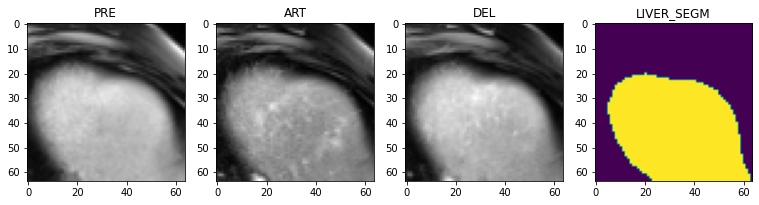

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: -0.23617620766162872
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: -0.24719415605068207
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: -0.23480212688446045


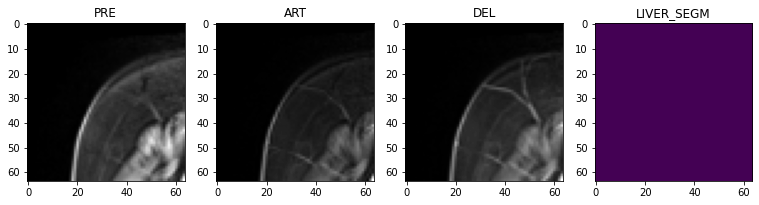

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.8933489918708801
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 1.0586379766464233
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 1.1005512475967407


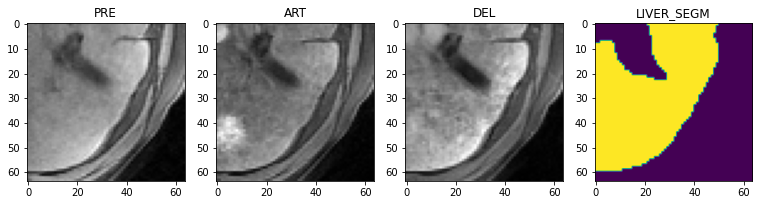

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7057956457138062
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.8620611429214478
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.9701210260391235


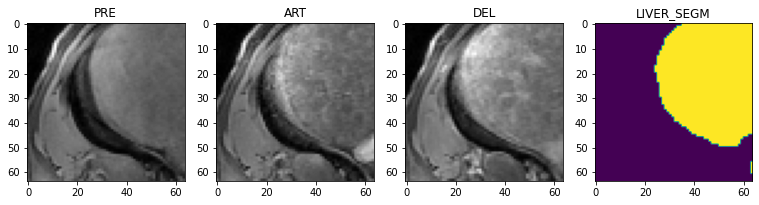

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 1.0327656269073486
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 1.3748390674591064
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 1.2416855096817017


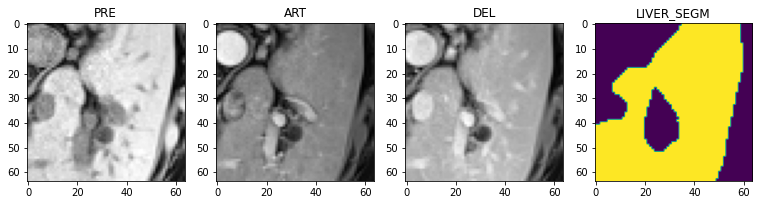

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.72822105884552
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.9174577593803406
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.8038544654846191


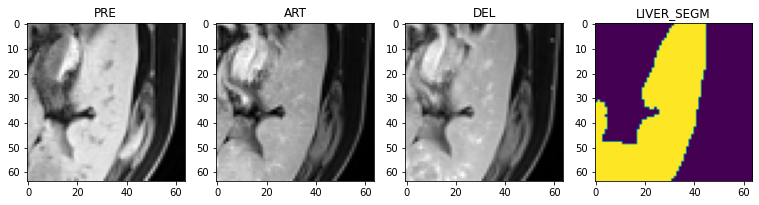

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.10764294862747192
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.12466755509376526
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.08991271257400513


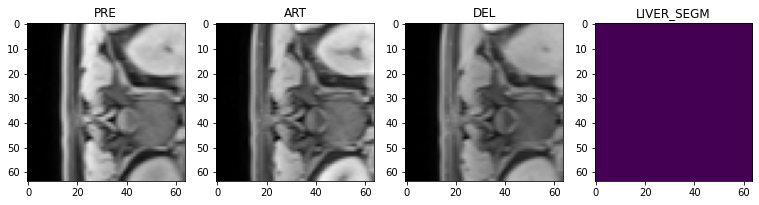

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.6901369690895081
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.7096458673477173
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.6069985032081604


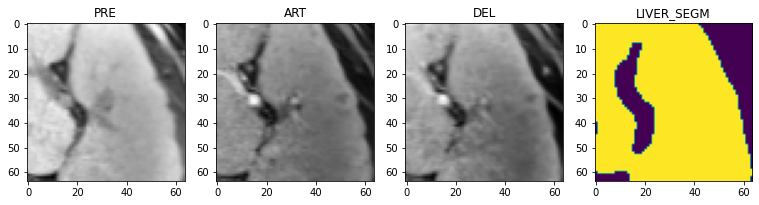

In [14]:
check_ds = monai.data.Dataset(data=train_data_dict[:10], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[10:11], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['ART'].shape)
print(check_data['DEL'].shape)


num_display = 10
if check_data['PRE'].shape[0] < num_display:
    num_display = check_data['PRE'].shape[0]

for i in range(num_display):
    PRE, ART, DEL , liver_label = (check_data['PRE'][i][0],check_data['ART'][i][0],check_data['DEL'][i][0], check_data['SEGM'][i][0])


    
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))
    
    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))



    slice_num = PRE.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 4, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 4, 2)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 4 ,4)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    
    plt.show()



    


## Create Segmentation Model (U-net)

In [15]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=3, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):

        pre_images =  batch["PRE"]
        art_images =  batch["ART"]
        del_images =  batch["DEL"]
        
        images = torch.cat((pre_images, art_images, del_images) ,dim=1)
        labels = batch["SEGM"]

        
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,3,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        
        
        pre_images =  batch["PRE"]
        art_images =  batch["ART"]
        del_images =  batch["DEL"]

        
        images = torch.cat((pre_images, art_images, del_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images = batch["IMAGE"]
        #labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [16]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,3,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       9,618
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,189,649
Trainable params: 1,189,649
Non-trainable params: 0
Total mult-adds (G): 1.70
Input size (MB): 1.57
Forward/backward pass size (MB): 45.22
Params size (MB): 4.76
Estimated Total Size (MB):

## Model Training

In [17]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-ART-DEL-Net/'


In [18]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [19]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=0760-val_loss=0.07.ckpt')

In [20]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [21]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        if keep:
            dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
        else:
                
            # Calculate Dice on the raw output
            dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            
            
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pre_images =  test_data["PRE"].to(device)
            art_images =  test_data["ART"].to(device)
            del_images =  test_data["DEL"].to(device)

            x = torch.cat((pre_images, art_images, del_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pre_img = pre_images.detach().cpu()
                art_img = art_images.detach().cpu()
                del_img = del_images.detach().cpu()



                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 5, 1)
                plt.title('PRE')
                plt.imshow(pre_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 2)
                plt.title('ART')
                plt.imshow(art_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 3)
                plt.title('DEL')
                plt.imshow(del_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 4)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 5, 5)
                plt.title('PRED')
                plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['ART_meta_dict']['affine'][0].numpy()
                original_affine = test_data['ART_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['ART_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['ART_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [22]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL'

0it [00:00, ?it/s]

0.941642165184021
37.762114188079586
inf
0.965933084487915
1.4037581029637554
inf
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


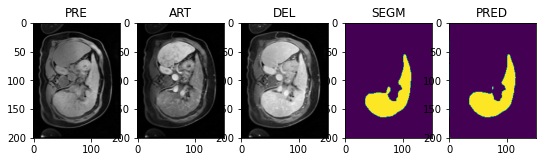

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E100998852_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 49 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 50 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.9682594537734985
34.97841809993228
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 47 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 49 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9765435457229614
1.3977617709149794
0.3385600998328501
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


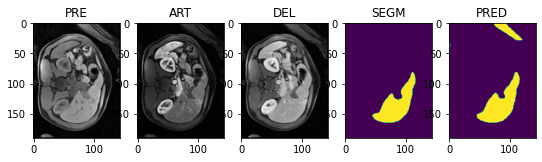

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/12370686_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.9479134678840637
9.864454133069934
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9710586071014404
1.1271926050184158
inf
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


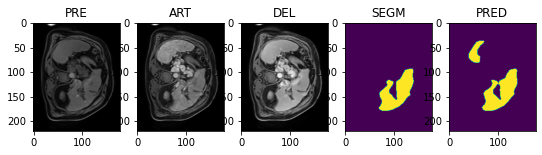

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104184251_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 219 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 219 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 220 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.9380294680595398
27.554377212029213
inf
0.9619358777999878
1.784499467226261
inf
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


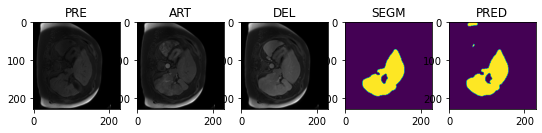

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E100353838_T1_ART_segm.nii.gz
0.9224064350128174
13.030427330264022
inf
0.9244274497032166
7.378808290769195
inf
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


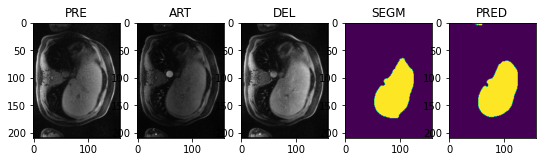

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/11655071_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 161 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 162 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 163 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163:

0.9512128829956055
28.051336190091078
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 160 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 161 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 162 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: 

0.955763578414917
1.2580655542873451
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


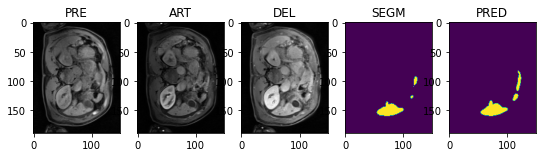

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105258820_T1_ART_segm.nii.gz
0.9487403035163879
4.518933403094342
inf
0.9488524198532104
3.523486560678899
inf
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


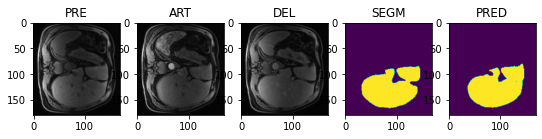

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/10782833_T1_ART_segm.nii.gz
0.9794828295707703
9.978399245748824
inf
0.9808611869812012
1.1286140219346206
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


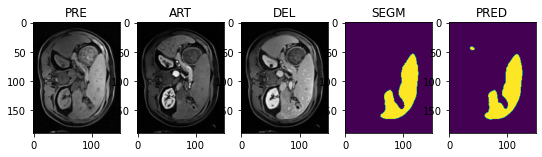

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105047582_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 159 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.9626480937004089
5.187368995625396
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 159 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: 

0.9636482000350952
1.3840045137509338
0.43521795184135303
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


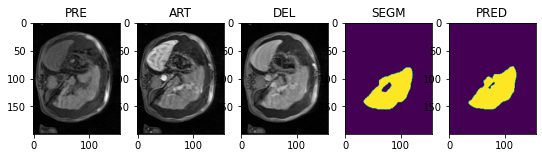

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E100559269_T1_ART_segm.nii.gz
0.8804550766944885
12.843189366535519
inf
0.880456268787384
12.843189366535519
inf
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


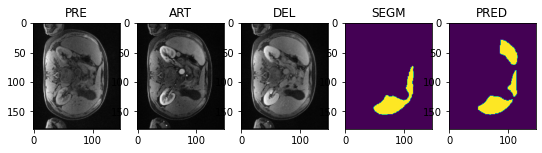

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/11157922_T1_ART_segm.nii.gz
0.9693903923034668
5.4138119318298275
inf
0.9717726707458496
1.7881793570626503
inf
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


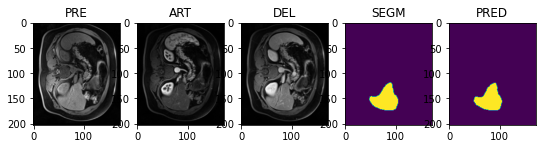

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E103977998_T1_ART_segm.nii.gz
0.9570127129554749
32.10612857658656
inf
0.9595756530761719
5.767934841286947
inf
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


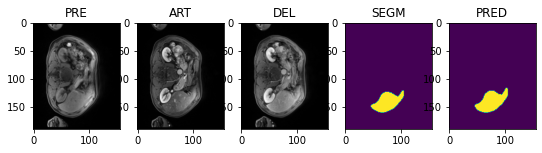

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E106605970_T1_ART_segm.nii.gz
0.9348740577697754
20.858626638424933
inf
0.945586621761322
4.781085695565314
inf
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


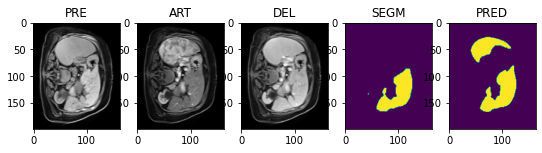

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E101166449_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 77 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 78 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.9487272500991821
40.42535142418358
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 75 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 76 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 77 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9621078968048096
2.7012579409973343
inf
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


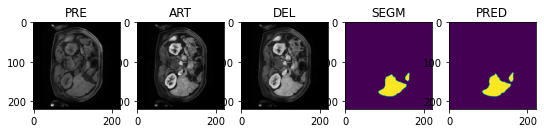

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E101693803_T1_ART_segm.nii.gz
0.9407679438591003
41.48406751605542
inf
0.9648182392120361
1.3854307893829345
inf
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


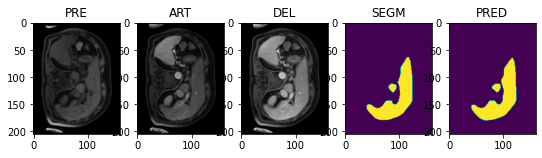

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E100488381_T1_ART_segm.nii.gz
0.9440913200378418
22.272723583496603
inf
0.946149468421936
3.5489561001875884
inf
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


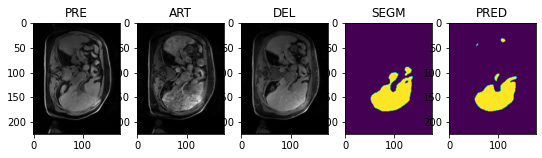

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E101446184_T1_ART_segm.nii.gz
0.9256950616836548
25.38333515351577
inf
0.9330431222915649
2.1276701145789194
inf
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


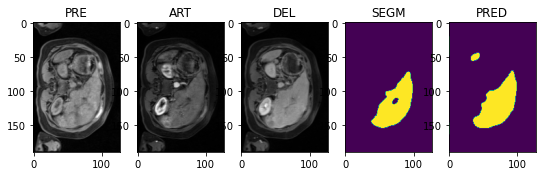

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/12132879_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 84 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarnin

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 84 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the g

0.9678696393966675
1.1335009474615059
inf
0.9678696393966675
1.1335009474615059
inf
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


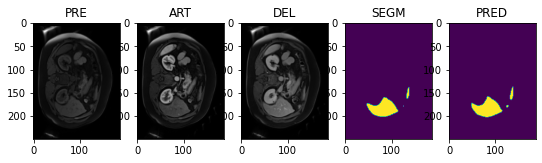

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E100207522_T1_ART_segm.nii.gz
0.9365708231925964
16.456550177681876
inf
0.9663445949554443
1.620250282240368
inf
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


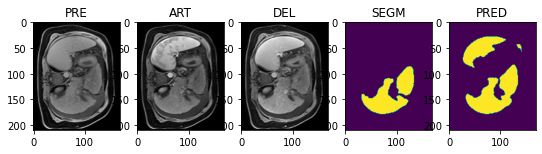

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104350920_T1_ART_segm.nii.gz
0.9611612558364868
5.859425514538442
inf
0.9630758762359619
1.7837339190541068
inf
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


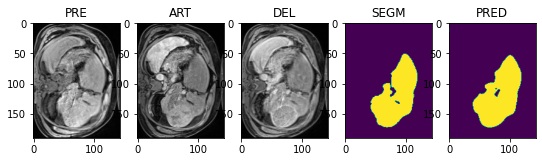

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E103442524_T1_ART_segm.nii.gz
0.9481522440910339
11.51871796254271
inf
0.9595116376876831
2.881608885587341
inf
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


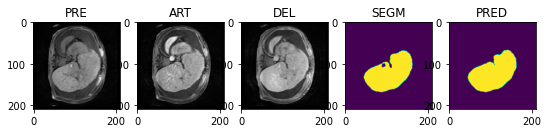

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E100354995_T1_ART_segm.nii.gz
0.9620962142944336
7.548225317427561
inf
0.9717046022415161
1.5663235501221198
inf
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


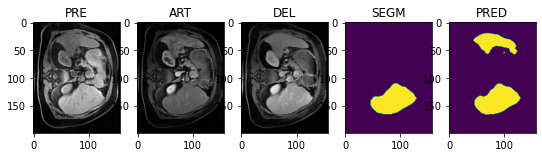

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/12169194_T1_ART_segm.nii.gz
0.9379862546920776
38.59493429160311
inf
0.9530525803565979
1.4689838421886063
inf
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


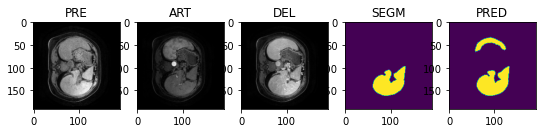

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/9464709_T1_ART_segm.nii.gz
0.9487868547439575
20.526688434501786
inf
0.9711301326751709
1.1699143258449132
inf
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


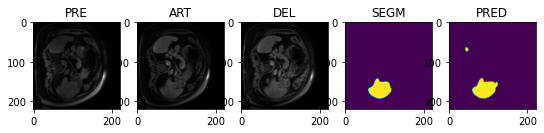

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E102885531_T1_ART_segm.nii.gz
0.9668490290641785
16.48542183088164
inf
0.9710921049118042
1.643179473697651
inf
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


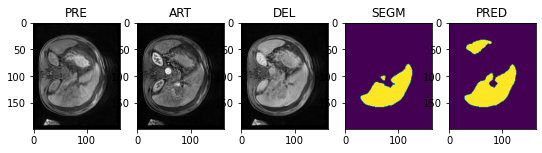

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E106731917_T1_ART_segm.nii.gz
0.9666571617126465
6.965535846932401
inf
0.9671566486358643
4.096805141819915
inf
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


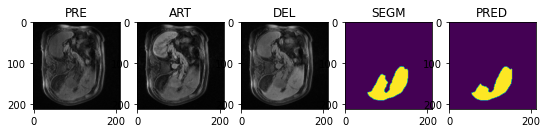

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105877173_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: Use

0.9301173686981201
32.745875867679985
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: th

0.9528954029083252
1.8615925778264162
inf
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


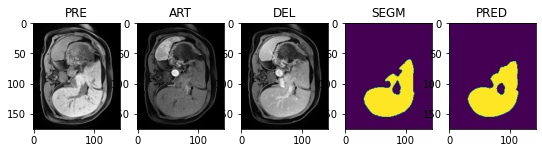

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E106096969_T1_ART_segm.nii.gz
0.9605525732040405
28.409240809594763
inf
0.9628682136535645
1.5268542811238053
inf
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


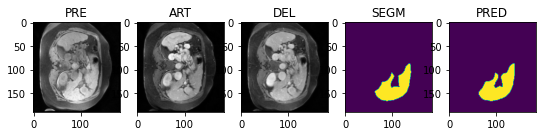

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/11571840_T1_ART_segm.nii.gz
0.9676851034164429
1.493849640862545
inf
0.9676851034164429
1.493849640862545
inf
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


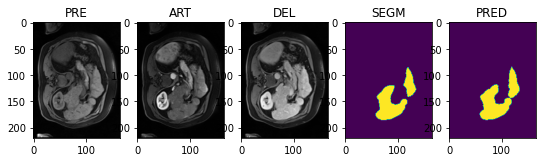

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E101753253_T1_ART_segm.nii.gz
0.9701412320137024
3.7593640935373176
inf
0.9710587859153748
1.2250849895335145
inf
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


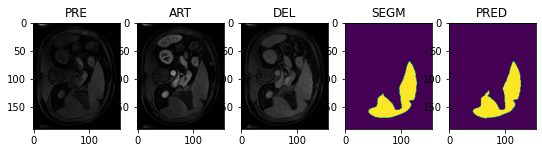

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E103922902_T1_ART_segm.nii.gz
0.9447055459022522
11.021254306363282
inf
0.9639379978179932
2.2516132064674514
inf
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


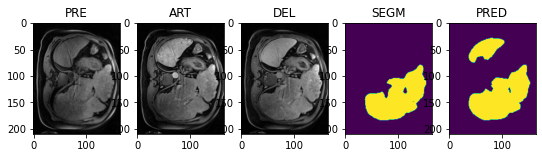

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E101453378_T1_ART_segm.nii.gz
0.9225271940231323
16.64409026460756
inf
0.9260672330856323
8.701194452142168
inf
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


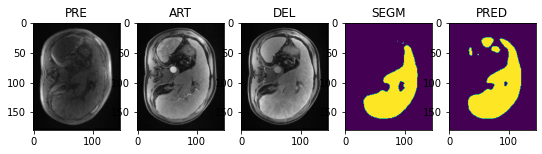

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/11397044_T1_ART_segm.nii.gz
0.9615927934646606
13.313029192063977
inf
0.9632952213287354
1.5576517991112033
inf
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


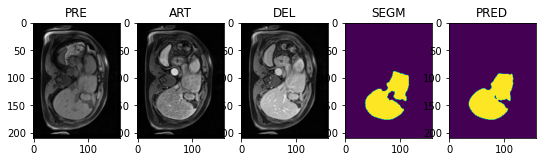

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/12922235_T1_ART_segm.nii.gz
0.9525060653686523
41.67202989291278
inf
0.9753597974777222
1.504161671603271
0.37822668485908084
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


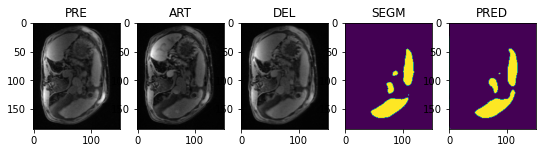

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/10939089_T1_ART_segm.nii.gz
0.9534683227539062
5.244562273121501
inf
0.9562641978263855
1.5858575381951294
inf
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


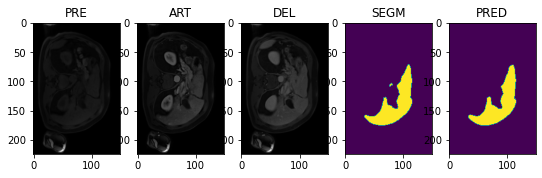

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/12957044_T1_ART_segm.nii.gz
0.966377854347229
4.000195549931653
inf
0.966713547706604
2.772349770468812
inf
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


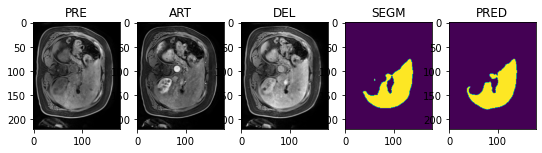

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E107891018_T1_ART_segm.nii.gz
0.9694236516952515
19.583073649521296
inf
0.9738075733184814
1.4754564962743075
inf
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


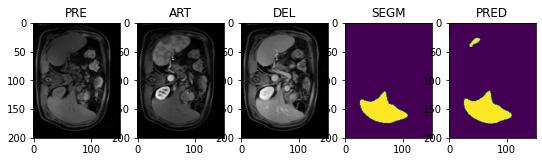

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104332583_T1_ART_segm.nii.gz
0.9591938257217407
22.064287495636627
inf
0.966752827167511
3.5722625072850738
inf
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


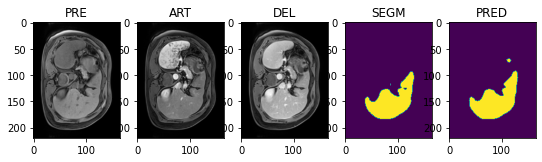

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E101547088_T1_ART_segm.nii.gz
0.9689551591873169
4.827356869793958
inf
0.9703404903411865
1.6027605293502893
inf
torch.Size([1, 2, 195, 147, 139])
torch.Size([1, 195, 147, 139])


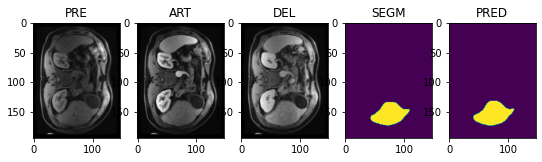

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/11524268_T1_ART_segm.nii.gz
0.9706796407699585
2.9642535447327214
inf
0.9714916944503784
1.428585836798599
inf
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


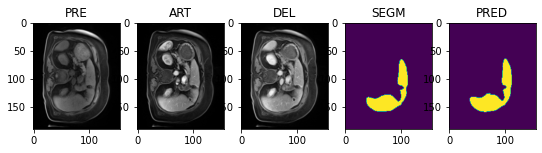

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E106458466_T1_ART_segm.nii.gz
0.9300050735473633
44.44304192580389
inf
0.9489505887031555
2.6738638296916877
inf
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


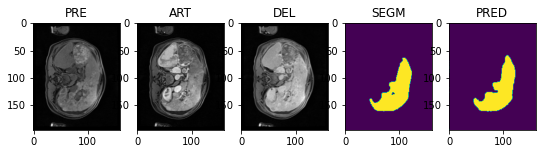

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E107235152_T1_ART_segm.nii.gz
0.9296324253082275
9.674313479549713
inf
0.9650768041610718
1.9298892342374983
0.5056174293525295
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


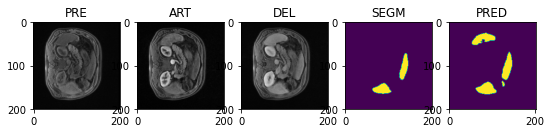

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105198762_T1_ART_segm.nii.gz
0.9253667593002319
23.765623068413074
inf
0.9405326247215271
4.356059956427991
inf
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


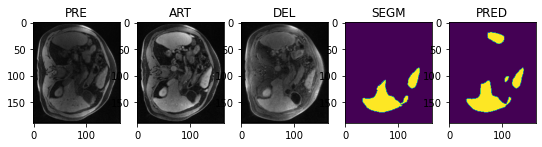

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/11148247_T1_ART_segm.nii.gz
0.96722412109375
5.27830816617368
inf
0.9677730798721313
1.913371622620234
0.45456119483986146
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


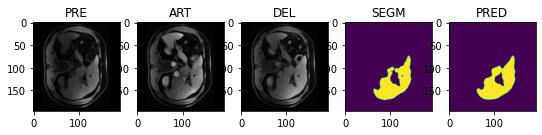

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E106751045_T1_ART_segm.nii.gz
0.9488520622253418
3.9182783084687145
inf
0.9495385885238647
2.649816988225039
inf
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


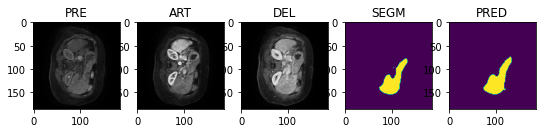

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/9648994_T1_ART_segm.nii.gz
0.967318058013916
2.3163127871800446
inf
0.9674410223960876
1.5800694009366583
0.39076133591535667
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


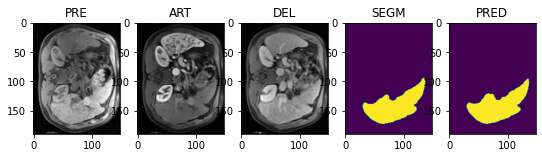

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E102928841_T1_ART_segm.nii.gz
0.9477142095565796
19.95423411652399
inf
0.968451201915741
1.4604953189350875
0.39532431933782197
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


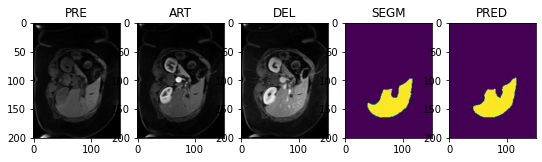

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105426183_T1_ART_segm.nii.gz
0.9674524664878845
3.663896855965937
inf
0.9682355523109436
1.6270622705991213
inf
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


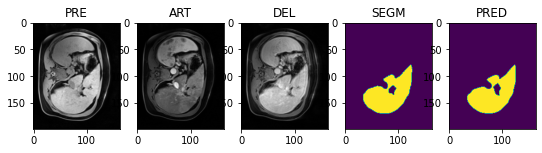

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E100142484_T1_ART_segm.nii.gz
0.9650288224220276
2.364128800566642
inf
0.9650370478630066
2.361483297921139
inf
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


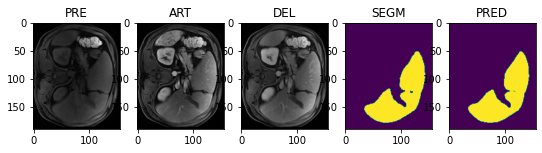

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105829099_T1_ART_segm.nii.gz
0.9285602569580078
4.9329264145266185
inf
0.9289467930793762
4.188516951436453
inf
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


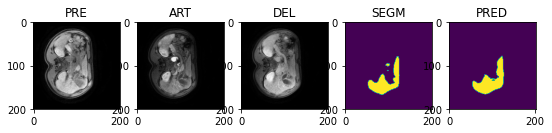

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/9586289_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 142 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 143 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 144 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.8541069626808167
25.93442850977425
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 142 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 143 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 144 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.8585320711135864
14.025209751726273
inf
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


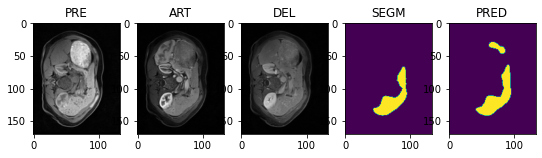

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E107156072_T1_ART_segm.nii.gz
0.9619810581207275
27.731381869929056
inf
0.9666266441345215
1.4135420017869573
inf
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


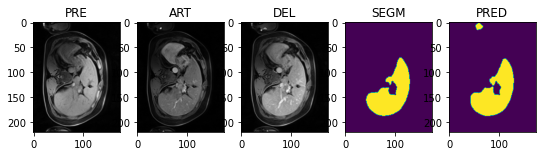

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104998309_T1_ART_segm.nii.gz
0.9688504338264465
11.494072551655634
inf
0.9707651138305664
1.2817675044531485
inf
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


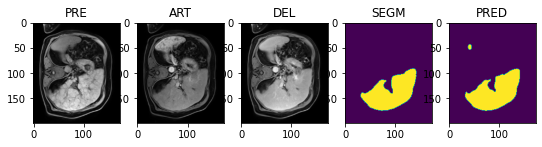

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105615985_T1_ART_segm.nii.gz
0.971336305141449
9.506793824065763
inf
0.9724990129470825
1.132858641292958
inf
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


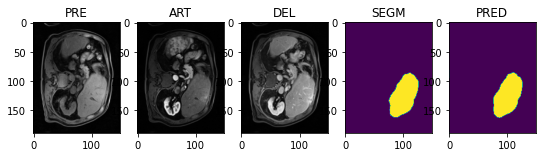

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/12916368_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 88 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 90 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.9597184658050537
6.104260177857479
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 90 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 92 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9605156183242798
2.1939107050738897
inf
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


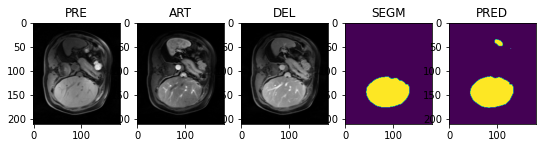

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E103814356_T1_ART_segm.nii.gz
0.9657301306724548
29.023825254097613
inf
0.9697949290275574
2.070261716776525
inf
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


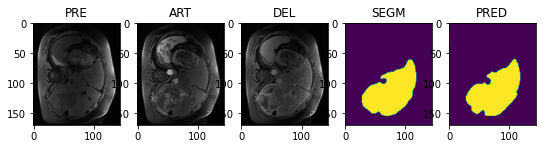

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/11022925_T1_ART_segm.nii.gz
0.9492512941360474
38.59604619605464
inf
0.960708737373352
1.4737932822721682
inf
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


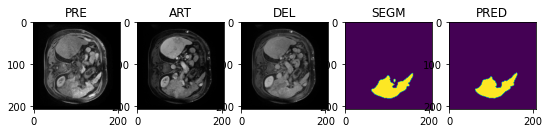

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E106533478_T1_ART_segm.nii.gz
0.9602426886558533
26.507844610821788
inf
0.9671716690063477
1.9869266748023882
inf
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


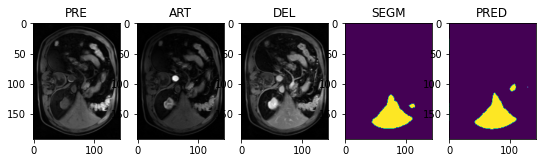

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E106851724_T1_ART_segm.nii.gz
0.9376760721206665
6.818253329413449
inf
0.9385159015655518
2.965436941466372
inf
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


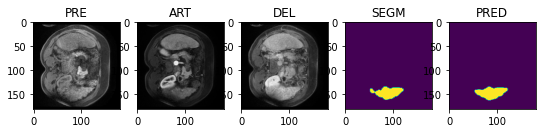

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E103511968_T1_ART_segm.nii.gz
0.9687172174453735
17.17683754698215
inf
0.9736764430999756
1.3220248737145828
0.35359555555221867
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


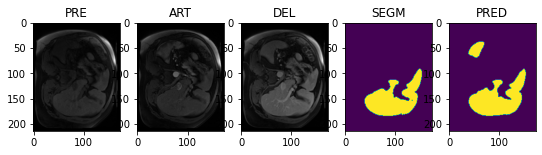

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E107553107_T1_ART_segm.nii.gz
0.9136756658554077
45.402912201199854
inf
0.9552308917045593
3.398604463165004
inf
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


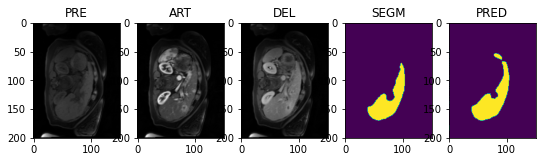

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E100588448_T1_ART_segm.nii.gz
0.9512115716934204
2.4756972268243507
inf
0.951215386390686
2.4756972268243507
inf
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


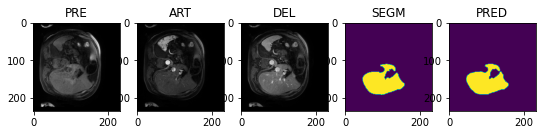

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104134228_T1_ART_segm.nii.gz
0.9399528503417969
45.430289321077105
inf
0.9605716466903687
1.3866188543512907
inf
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


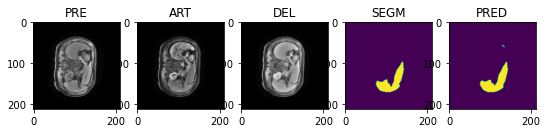

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E101686218_T1_ART_segm.nii.gz
0.935818076133728
32.62430949079274
inf
0.944422721862793
2.6215775113533066
inf
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


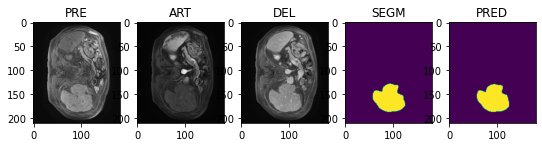

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E100967188_T1_ART_segm.nii.gz
0.9626873731613159
4.439696795567858
inf
0.9635377526283264
2.053424474139288
inf
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


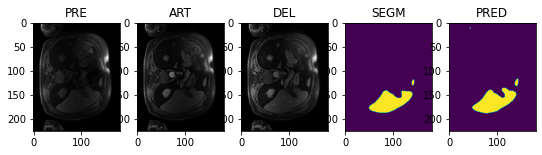

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E107476766_T1_ART_segm.nii.gz
0.9182150959968567
16.82909331441433
inf
0.9552412033081055
1.4921383262847645
0.4127639400644375
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


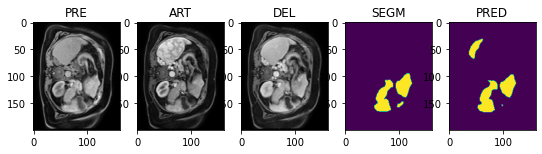

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104250009_T1_ART_segm.nii.gz
0.9784971475601196
2.5085207375318967
inf
0.9787369966506958
1.2016111897932038
0.29769428020326555
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


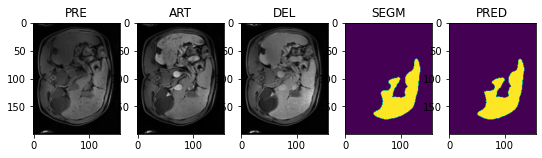

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105152299_T1_ART_segm.nii.gz
0.9268897771835327
44.290162550923725
inf
0.9457010626792908
1.5624121267505386
inf
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


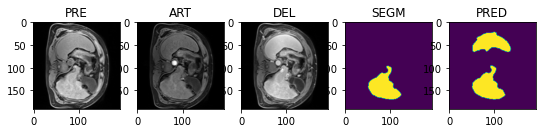

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/11308203_T1_ART_segm.nii.gz
0.9582082033157349
30.41990281474333
inf
0.97371506690979
1.3907500138809115
inf
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


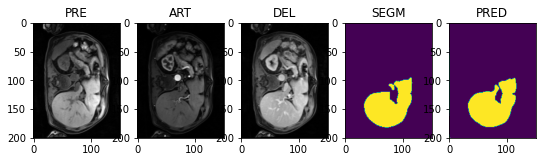

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E107046127_T1_ART_segm.nii.gz
0.9615917205810547
4.863160966874403
inf
0.9635879993438721
1.376327937504604
inf
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


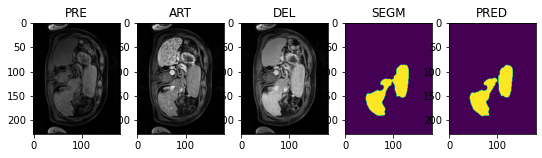

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/13106408_T1_ART_segm.nii.gz
0.9675165414810181
25.87259571877083
inf
0.9756256341934204
1.0802148149132704
0.29573749302681546
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


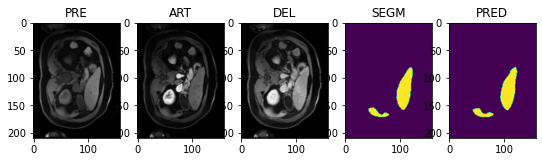

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E102486953_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.9139612913131714
16.06319991628401
inf
0.9561840295791626
2.061348832776793
inf
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


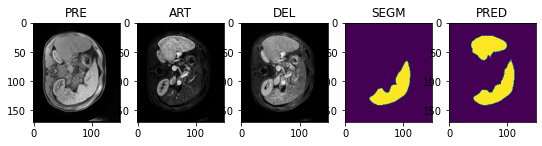

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E101055640_T1_ART_segm.nii.gz
0.9687969088554382
5.204726099863425
inf
0.9688230752944946
5.198764489254126
inf
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


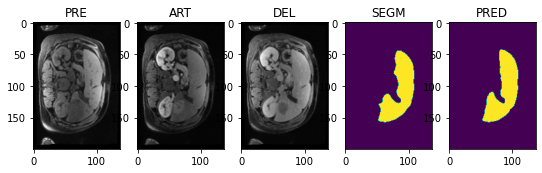

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/10807315_T1_ART_segm.nii.gz
0.9304043650627136
11.826978531019616
inf
0.9798463582992554
1.3213665540599566
0.2663737698834762
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


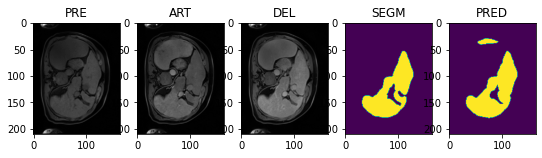

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/13170972_T1_ART_segm.nii.gz
0.925330400466919
13.302825434195018
inf
0.9255894422531128
10.951282251362606
inf
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


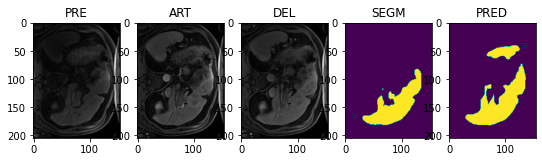

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104594843_T1_ART_segm.nii.gz
0.9765549898147583
3.486738166885658
inf
0.977019190788269
1.4856890587556286
inf
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


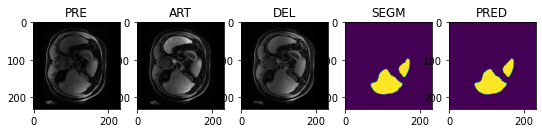

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104034609_T1_ART_segm.nii.gz
0.9434553384780884
10.85316652211634
inf
0.9587182998657227
1.6700488382744387
inf
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


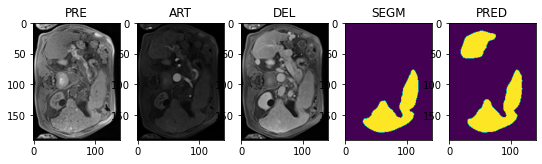

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E107774979_T1_ART_segm.nii.gz
0.9652611017227173
2.1473421990651103
inf
0.9655073881149292
1.3805791338282147
inf
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


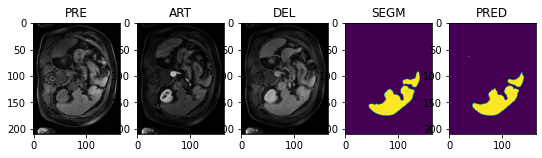

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104900599_T1_ART_segm.nii.gz
0.9777597188949585
1.6915737628437053
inf
0.9778211116790771
1.3016174309659754
inf
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


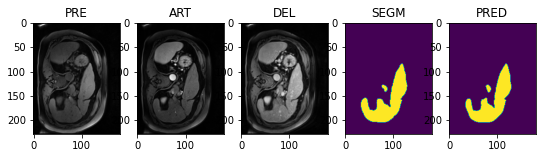

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E104657225_T1_ART_segm.nii.gz
0.9371497631072998
28.560284921203365
inf
0.9563711881637573
2.565009982335624
inf
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


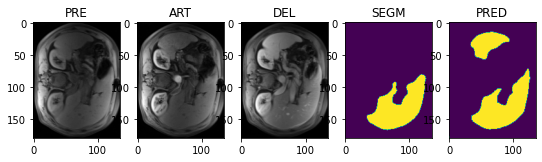

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105599954_T1_ART_segm.nii.gz
0.9273892641067505
16.176435873884174
inf
0.9285455942153931
9.894449035639367
inf
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


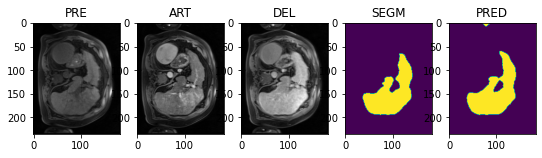

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E103570649_T1_ART_segm.nii.gz
0.9482053518295288
7.345535638503842
inf
0.9482448101043701
7.342520563126956
inf
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


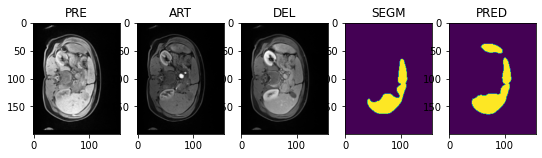

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E105504009_T1_ART_segm.nii.gz
0.9487961530685425
11.563028475600879
inf
0.96760094165802
1.6009103446968558
0.4872745408080558
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


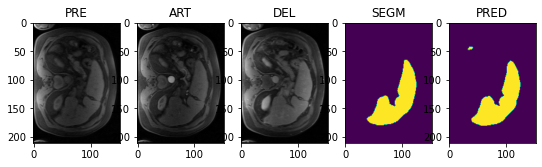

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E103831361_T1_ART_segm.nii.gz
0.965651273727417
2.75705901115607
inf
0.9659863710403442
2.3310668172032174
inf
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


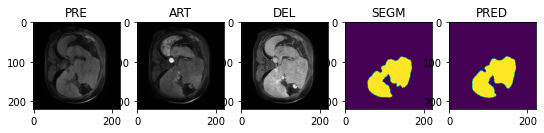

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/10843891_T1_ART_segm.nii.gz
0.9554898738861084
4.2150148810807595
inf
0.9566030502319336
1.9415520440230924
inf
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


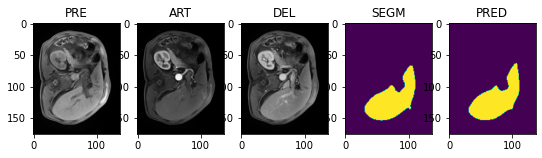

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E101762106_T1_ART_segm.nii.gz
0.950799822807312
24.41264626803589
inf
0.9548721313476562
1.9283414016261597
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


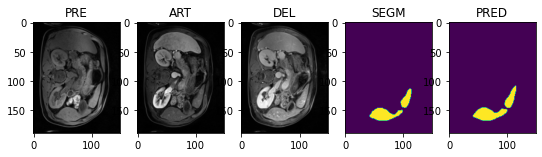

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/12543786_T1_ART_segm.nii.gz
0.9556784629821777
5.08812593087617
inf
0.9569346904754639
1.6643538101450859
inf
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


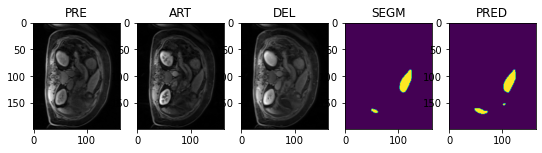

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E107077373_T1_ART_segm.nii.gz
0.9702656269073486
4.54277782676498
inf
0.9707860946655273
1.286935771437467
inf
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


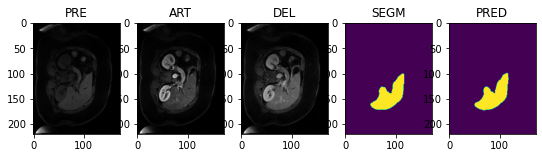

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/PRE-ART-DEL/E106501028_T1_ART_segm.nii.gz
[0.941642165184021, 0.9682594537734985, 0.9479134678840637, 0.9380294680595398, 0.9224064350128174, 0.9512128829956055, 0.9487403035163879, 0.9794828295707703, 0.9626480937004089, 0.8804550766944885, 0.9693903923034668, 0.9570127129554749, 0.9348740577697754, 0.9487272500991821, 0.9407679438591003, 0.9440913200378418, 0.9256950616836548, 0.9678696393966675, 0.9365708231925964, 0.9611612558364868, 0.9481522440910339, 0.9620962142944336, 0.9379862546920776, 0.9487868547439575, 0.9668490290641785, 0.9666571617126465, 0.9301173686981201, 0.9605525732040405, 0.9676851034164429, 0.9701412320137024, 0.9447055459022522, 0.9225271940231323, 0.9615927934646606, 0.9525060653686523, 0.9534683227539062, 0.966377854347229, 0.9694236516952515, 0.9591938257217407, 0.9689551591873169, 0.9706796407699585, 0.9300050735473633, 0.9296324253082275, 0.9253667593002319, 0.967224121

DICE  POST_DICE       HD95  POST_HD95  InferenceTime  \
0  0.941642   0.965933  37.762114   1.403758       0.006895   
1  0.968259   0.976544  34.978418   1.397762       0.006848   
2  0.947913   0.971059   9.864454   1.127193       0.004517   
3  0.938029   0.961936  27.554377   1.784499       0.012642   
4  0.922406   0.924427  13.030427   7.378808       0.004063   

                                AUTOMATED-LIVER-SEGM       EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-DEL  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-DEL  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-DEL  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-DEL  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-PRE-ART-DEL

In [63]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
    output_path= OUTPUT_PATH)
    #max_eval = 2)


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = '3mpMRI-PRE-ART-DEL'
df_test_results.head()

In [65]:
df_test_results.to_csv('../Results/Results-3mpMRI-Net_PRE-ART-DEL.csv')